## The following notebook gives an example analysis that we can do with our loaded election data.

## Our motivating question is: how have Democrats performed in competitive state legislature races over the last ten years? We're going to look at the number and win rates of races where the Democrat and Republican came within five points in either a State House or State Senate race.

## We load our data using sqlalchemy and our shared password key which is stored through and environmental variable.

In [4]:
import os

import pandas as pd
from sqlalchemy import create_engine

def read_query(query):
    pwd = os.environ["SHARED_PASSWORD"]
    con = create_engine("postgres://shared:{}@postgres/shared".format(pwd))
    return pd.read_sql(query, con)  

## We construct a query to join the votes table to its relevant lookups. This will be called the results table, as we do another join to get the vote totals for each election.

In [18]:
results_query = """
SELECT
    election_year,
    office_description,
    office_code,
    district_code,
    status_code,
    candidate_id,
    candidate_party_name,
    candidate_first_name,
    candidate_last_name,
    candidate_middle_name,
    candidate_votes    
FROM (
    SELECT * FROM (
        SELECT
            election_year,
            office_code,
            district_code,
            status_code,
            candidate_id,
            SUM(precinct_votes) AS candidate_votes
        FROM vote
        WHERE office_code != 0
        GROUP BY
            election_year,
            office_code,
            district_code,
            status_code,
            candidate_id
    ) AS votes
    JOIN (
        SELECT
            election_year AS election_year2,
            office_code AS office_code2,
            district_code AS district_code2,
            status_code AS status_code2,
            office_description
        FROM offices
        GROUP BY
            election_year,
            office_code,
            district_code,
            status_code,
            office_description
    ) AS office_lookup
    ON 
        votes.election_year = office_lookup.election_year2 
        AND votes.office_code = office_lookup.office_code2
        AND votes.district_code = office_lookup.district_code2
        AND votes.status_code = office_lookup.status_code2
    JOIN (
        SELECT
            election_year as election_year3,
            candidate_id AS candidate_id3,
            candidate_party_name,
            candidate_first_name,
            candidate_last_name,
            candidate_middle_name
        FROM name
        GROUP BY 
            election_year,
            candidate_id,
            candidate_party_name,
            candidate_first_name,
            candidate_last_name,
            candidate_middle_name
    ) AS candidate_lookup
    ON
        votes.election_year = candidate_lookup.election_year3
        AND votes.candidate_id = candidate_lookup.candidate_id3
) AS results
"""
results = read_query(results_query)
results.head()

election_year                                 office_description  \
0           2008  PRESIDENT OF THE UNITED STATES 4 YEAR TERM (1)...   
1           2008  PRESIDENT OF THE UNITED STATES 4 YEAR TERM (1)...   
2           2008  PRESIDENT OF THE UNITED STATES 4 YEAR TERM (1)...   
3           2008  PRESIDENT OF THE UNITED STATES 4 YEAR TERM (1)...   
4           2008  PRESIDENT OF THE UNITED STATES 4 YEAR TERM (1)...   

   office_code  district_code  status_code  candidate_id candidate_party_name  \
0            1              0            0          -634                  NPA   
1            1              0            0          -633                  NPA   
2            1              0            0          -623                  DEM   
3            1              0            0          -621                  REP   
4            1              0            0          -615                  NLP   

  candidate_first_name candidate_last_name candidate_middle_name  \
0                BRIAN               MOORE                  None   
1                 ALAN               KEYES                  None   
2               BARACK               OBAMA                  None   
3                 JOHN              MCCAIN                  None   
4                RALPH               NADER                  None   

   candidate_votes  
0             41.0  
1            129.0  
2        2872579.0  
3        2048639.0  
4          33085.0

## We run a similar query to get vote totals for each district.

In [21]:
total_query = """
SELECT
    election_year,
    office_code,
    district_code,
    status_code,
    SUM(precinct_votes) AS total_votes
FROM vote
WHERE office_code != 0
GROUP BY
    election_year,
    office_code,
    district_code,
    status_code
"""
totals = read_query(total_query)
totals.head()

election_year  office_code  district_code  status_code  total_votes
0           2008            1              0            0    5001766.0
1           2008            5              0            0    4848620.0
2           2008            6            100            0     327836.0
3           2008            6            200            0     343309.0
4           2008            6            300            0     333518.0

## We now join them together to get vote percentages using pandas.

In [23]:
analysis_df = pd.merge(
    results,
    totals,
    on = ['election_year', 'office_code', 'district_code', 'status_code']
)
analysis_df['vote_percent'] = analysis_df['candidate_votes']/analysis_df['total_votes']
analysis_df.head()

election_year                                 office_description  \
0           2008  PRESIDENT OF THE UNITED STATES 4 YEAR TERM (1)...   
1           2008  PRESIDENT OF THE UNITED STATES 4 YEAR TERM (1)...   
2           2008  PRESIDENT OF THE UNITED STATES 4 YEAR TERM (1)...   
3           2008  PRESIDENT OF THE UNITED STATES 4 YEAR TERM (1)...   
4           2008  PRESIDENT OF THE UNITED STATES 4 YEAR TERM (1)...   

   office_code  district_code  status_code  candidate_id candidate_party_name  \
0            1              0            0          -634                  NPA   
1            1              0            0          -633                  NPA   
2            1              0            0          -623                  DEM   
3            1              0            0          -621                  REP   
4            1              0            0          -615                  NLP   

  candidate_first_name candidate_last_name candidate_middle_name  \
0                BRIAN               MOORE                  None   
1                 ALAN               KEYES                  None   
2               BARACK               OBAMA                  None   
3                 JOHN              MCCAIN                  None   
4                RALPH               NADER                  None   

   candidate_votes  total_votes  vote_percent  
0             41.0    5001766.0      0.000008  
1            129.0    5001766.0      0.000026  
2        2872579.0    5001766.0      0.574313  
3        2048639.0    5001766.0      0.409583  
4          33085.0    5001766.0      0.006615

## We'd like to get the Republican and Democratic vote share for each election. We do that by using iloc, and do some additional column filtering to simplify the future join.

In [33]:
republican_df = analysis_df.iloc[(analysis_df['candidate_party_name']=='REP').values]
republican_df.rename(index=str, columns={'candidate_votes': 'republican_votes','vote_percent': 'republican_vote_percent'}, inplace=True)
republican_summary = republican_df.loc[:, [
    'election_year',
    'office_description',
    'office_code',
    'district_code',
    'status_code',
    'republican_votes',
    'republican_vote_percent'
]]
republican_summary.head()

election_year                                 office_description  \
3            2008  PRESIDENT OF THE UNITED STATES 4 YEAR TERM (1)...   
13           2008     UNITED STATES SENATOR 6 YEAR TERM (1) POSITION   
17           2008  1ST DISTRICT REPRESENTATIVE IN CONGRESS 2 YEAR...   
23           2008  2ND DISTRICT REPRESENTATIVE IN CONGRESS 2 YEAR...   
27           2008  3RD DISTRICT REPRESENTATIVE IN CONGRESS 2 YEAR...   

    office_code  district_code  status_code  republican_votes  \
3             1              0            0         2048639.0   
13            5              0            0         1641070.0   
17            6            100            0          107340.0   
23            6            200            0          214100.0   
27            6            300            0          203799.0   

    republican_vote_percent  
3                  0.409583  
13                 0.338461  
17                 0.327420  
23                 0.623636  
27                 0.611058

## We do the same with Democrats.

In [34]:
democratic_df = analysis_df.iloc[(analysis_df['candidate_party_name']=='DEM').values]
democratic_df.rename(index=str, columns={'candidate_votes': 'democratic_votes','vote_percent': 'democratic_vote_percent'}, inplace=True)
democratic_summary = democratic_df.loc[:, [
    'election_year',
    'office_description',
    'office_code',
    'district_code',
    'status_code',
    'democratic_votes',
    'democratic_vote_percent'
]]
democratic_summary.head()

election_year                                 office_description  \
2            2008  PRESIDENT OF THE UNITED STATES 4 YEAR TERM (1)...   
12           2008     UNITED STATES SENATOR 6 YEAR TERM (1) POSITION   
18           2008  1ST DISTRICT REPRESENTATIVE IN CONGRESS 2 YEAR...   
24           2008  2ND DISTRICT REPRESENTATIVE IN CONGRESS 2 YEAR...   
26           2008  3RD DISTRICT REPRESENTATIVE IN CONGRESS 2 YEAR...   

    office_code  district_code  status_code  democratic_votes  \
2             1              0            0         2872579.0   
12            5              0            0         3038386.0   
18            6            100            0          213216.0   
24            6            200            0          119506.0   
26            6            300            0          117961.0   

    democratic_vote_percent  
2                  0.574313  
12                 0.626650  
18                 0.650374  
24                 0.348100  
26                 0.353687

## We join our party aggregations together to get a party results dataframe.

In [36]:
party_results = pd.merge(
    republican_summary,
    democratic_summary,
    on = [
        'election_year',
        'office_description',
        'office_code',
        'district_code',
        'status_code',
    ]
)
party_results.head()

election_year                                 office_description  \
0           2008  PRESIDENT OF THE UNITED STATES 4 YEAR TERM (1)...   
1           2008     UNITED STATES SENATOR 6 YEAR TERM (1) POSITION   
2           2008  1ST DISTRICT REPRESENTATIVE IN CONGRESS 2 YEAR...   
3           2008  2ND DISTRICT REPRESENTATIVE IN CONGRESS 2 YEAR...   
4           2008  3RD DISTRICT REPRESENTATIVE IN CONGRESS 2 YEAR...   

   office_code  district_code  status_code  republican_votes  \
0            1              0            0         2048639.0   
1            5              0            0         1641070.0   
2            6            100            0          107340.0   
3            6            200            0          214100.0   
4            6            300            0          203799.0   

   republican_vote_percent  democratic_votes  democratic_vote_percent  
0                 0.409583         2872579.0                 0.574313  
1                 0.338461         3038386.0                 0.626650  
2                 0.327420          213216.0                 0.650374  
3                 0.623636          119506.0                 0.348100  
4                 0.611058          117961.0                 0.353687

## We now apply our relevant logic for analysis. We construct a closeness flag, a flag for Democratic victories, and combine them to construct a close Dem win flag.

In [106]:
party_results['closeness_flag'] = party_results.apply(
    lambda x: 1 if abs(x['republican_vote_percent'] - x['democratic_vote_percent'])<0.05 else 0,
    axis=1
)
party_results['democratic_win'] = party_results.apply(
    lambda x: 1 if x['republican_vote_percent']<x['democratic_vote_percent'] else 0,
    axis=1
)
party_results['close_democratic_win'] = party_results['closeness_flag']*party_results['democratic_win']
party_results.head()

election_year                                 office_description  \
0           2008  PRESIDENT OF THE UNITED STATES 4 YEAR TERM (1)...   
1           2008     UNITED STATES SENATOR 6 YEAR TERM (1) POSITION   
2           2008  1ST DISTRICT REPRESENTATIVE IN CONGRESS 2 YEAR...   
3           2008  2ND DISTRICT REPRESENTATIVE IN CONGRESS 2 YEAR...   
4           2008  3RD DISTRICT REPRESENTATIVE IN CONGRESS 2 YEAR...   

   office_code  district_code  status_code  republican_votes  \
0            1              0            0         2048639.0   
1            5              0            0         1641070.0   
2            6            100            0          107340.0   
3            6            200            0          214100.0   
4            6            300            0          203799.0   

   republican_vote_percent  democratic_votes  democratic_vote_percent  \
0                 0.409583         2872579.0                 0.574313   
1                 0.338461         3038386.0                 0.626650   
2                 0.327420          213216.0                 0.650374   
3                 0.623636          119506.0                 0.348100   
4                 0.611058          117961.0                 0.353687   

   closeness_flag  democratic_win  close_democratic_win  
0               0               1                     0  
1               0               1                     0  
2               0               1                     0  
3               0               0                     0  
4               0               0                     0

## We now aggregate to the election year and office type by using groupby.

In [107]:
party_aggregated = party_results.groupby(
    ['election_year', 'office_code'])['close_democratic_win', 'closeness_flag'].sum().reset_index()
party_aggregated

election_year  office_code  close_democratic_win  closeness_flag
0            2008            1                     0               0
1            2008            5                     0               0
2            2008            6                     1               1
3            2008            8                     2               5
4            2008            9                     0               0
5            2008           10                     1               1
6            2008           11                     3               3
7            2008           12                     2               2
8            2010            2                     0               0
9            2010            3                     0               0
10           2010            4                     0               0
11           2010            6                     1               2
12           2010            7                     0               0
13           2010            8                     4               8
14           2010            9                     0               3
15           2010           10                     0               4
16           2010           11                     0               4
17           2010           12                     0               4
18           2012            1                     0               0
19           2012            5                     0               0
20           2012            6                     1               2
21           2012            8                     3               7
22           2012            9                     2               2
23           2012           10                     2               2
24           2012           11                     3               3
25           2012           12                     1               1
26           2014            2                     0               1
27           2014            3                     0               0
28           2014            4                     0               0
29           2014            5                     0               0
30           2014            6                     0               0
31           2014            7                     0               2
32           2014            8                     0               9
33           2014            9                     4               4
34           2014           10                     4               4
35           2014           11                     3               4
36           2014           12                     3               3
37           2016            1                     0               1
38           2016            6                     0               0
39           2016            7                     0               0
40           2016            8                     2               4
41           2016            9                     0               4
42           2016           10                     2               4
43           2016           11                     2               4
44           2016           12                     3               4

## We're only interested in State House and State Senate races, so we filter to its office code (7 and 8), and then calculate the win percentage.

In [108]:
state_leg = party_aggregated.iloc[(party_aggregated['office_code'].isin([7,8])).values]
state_leg_closeness = state_leg.groupby('election_year')['closeness_flag','close_democratic_win'].sum().reset_index()
state_leg_closeness['Win Percentage'] = state_leg_closeness['close_democratic_win']/state_leg_closeness['closeness_flag']
state_leg_closeness.rename(
    index=str,
    columns={
        'election_year': 'Election Year',
        'closeness_flag': 'Number of Elections'
    },
    inplace=True
)
state_leg_closeness

Election Year  Number of Elections  close_democratic_win  Win Percentage
0           2008                    5                     2        0.400000
1           2010                    8                     4        0.500000
2           2012                    7                     3        0.428571
3           2014                   11                     0        0.000000
4           2016                    4                     2        0.500000

## We plot our results by using a joint bar and line plot to get an idea of the number of close races against the win percentage in those races.

Text(0.5, 1.0, 'Dem Performance In Close Elections (+/- 5 pts)')

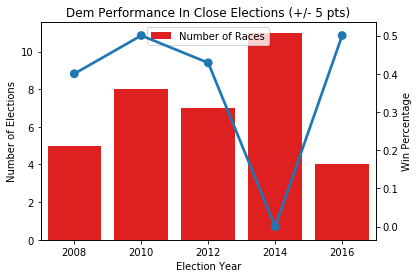

In [109]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(1, 1)

first_plot = sns.barplot(x=state_leg_closeness["Election Year"], y=state_leg_closeness["Number of Elections"], color='r', label='Number of Races')
ax2 = plt.twinx()
second_plot = sns.pointplot(x=state_leg_closeness["Election Year"], y=state_leg_closeness["Win Percentage"], ax=ax2, label='Win Percentage')
ax.legend(loc=9)
ax.set_title("Dem Performance In Close Elections (+/- 5 pts)")